In [173]:
import numpy as np                     # numpy
import pandas as pd                    # pandas
import librosa
import librosa.display
import subprocess

import matplotlib.pyplot as plt
import soundfile as sf

import os


from numpy.linalg import norm

In [174]:
%run "../Task2/Implementation.ipynb"

In [175]:
featureMatrixDF = createFeatureMatrixForDirectory(dir="../videos/processed")

In [176]:
# normalize
for column in featureMatrixDF:
    if column != 'File':
        featureMatrixDF[column] = (featureMatrixDF[column] - featureMatrixDF[column].min()) / (featureMatrixDF[column].max() - featureMatrixDF[column].min())  

In [177]:
featureMatrixDF

,File,RMS Std,Spectral Contrast Mean,Spectral Centroid Mean,ZeroCrossingR Std,ZeroCrossingR Mean,Tempogram Sum
0,01_DevilsAdvocate_02,0.105852,0.522271,0.000000,0.177125,0.000000,0.512326
0,01_DevilsAdvocate_03,0.653402,0.682190,0.672381,1.000000,0.578601,0.164595
0,01_DevilsAdvocate_04,0.791202,0.500065,0.725581,0.829802,0.726320,0.211007
0,01_DevilsAdvocate_05,0.370287,0.309321,0.440698,0.175284,0.413172,0.558203
0,01_PulpFiction_02,0.391747,0.481213,0.532761,0.457493,0.595151,0.812657
0,01_PulpFiction_03,0.345640,0.414588,0.553514,0.389439,0.587924,0.578747
0,01_PulpFiction_04,0.367646,0.712223,0.485682,0.000000,0.474172,0.367369
0,01_PulpFiction_05,0.000000,0.474136,0.460742,0.508857,0.466404,0.567074
0,02_HowSheMove_02,1.000000,0.396915,0.563299,0.375247,0.470414,0.149355
0,02_HowSheMove_03,0.420459,0.449503,0.409688,0.064186,0.345984,0.463496


In [179]:
def evaluateQueryEngine(dir: str):
    featureMatrixDF = createFeatureMatrixForDirectory(dir=dir)
    # normalize
    for column in featureMatrixDF:
        if column != 'File':
            featureMatrixDF[column] = (featureMatrixDF[column] - featureMatrixDF[column].min()) / (featureMatrixDF[column].max() - featureMatrixDF[column].min())  
    
    featureMatrix = featureMatrixDF.to_numpy()
    for mainFeatureVector in featureMatrix:
        
        evaluationFrame = pd.DataFrame(columns=['File', 'Relevance', 'Cosine Similarity', 'Precision', 'Recall', 'F'])
        
        # Cosine Similarity and adding to dataframe
        for compareFeatureVector in featureMatrix:
            if (mainFeatureVector!=compareFeatureVector).all(): #https://stackoverflow.com/questions/10580676/comparing-two-numpy-arrays-for-equality-element-wise #if vectors are not the same
                A = mainFeatureVector[1:] # all dimensions except the filename
                B = compareFeatureVector[1:]
                cosineSimilarity = np.dot(A,B)/(norm(A)*norm(B))
                newRow = pd.DataFrame.from_records([{ # add to frame
                        'File': compareFeatureVector[0],
                        'Cosine Similarity': cosineSimilarity
                    }])
                evaluationFrame = pd.concat([evaluationFrame, newRow])
        evaluationFrame = evaluationFrame.sort_values(by='Cosine Similarity', ascending=False)
        evaluationFrame.reset_index(drop=True, inplace=True) # making indices standardly incrementing
        
        # Relevance
        for fileName in evaluationFrame["File"]: # detect relevance
            if fileName[0:2] == mainFeatureVector[0][0:2]: # if they start with the same 2 characters
                evaluationFrame.loc[evaluationFrame['File'] == fileName, 'Relevance'] = 1
            else:
                evaluationFrame.loc[evaluationFrame['File'] == fileName, 'Relevance'] = 0
        
        # Precision, Recall and F-Measure
        retrievedCursor = 0
        relevantCursor = 0
        relevantItems = sum(evaluationFrame["Relevance"])
        for relevance in evaluationFrame["Relevance"]:
            retrievedCursor += 1
            relevantCursor += relevance
            
            precision = relevantCursor/retrievedCursor
            recall = relevantCursor/relevantItems
            
            evaluationFrame.loc[retrievedCursor - 1, 'Precision'] = precision # Set precision
            evaluationFrame.loc[retrievedCursor - 1, 'Recall'] = recall # Set recall
            
            # f-measure
            # beta = 0.5
            # -> 0.5^2 = (1-a) / a => a = 0.8
            beta = 0.5
            if precision > 0:
                fmeasure = ((pow(beta, 2)+1) * precision * recall) / (pow(beta, 2)*precision + recall)
            else:
                fmeasure = 0
            
            evaluationFrame.loc[retrievedCursor - 1, 'F'] = fmeasure # Set f-measure
            
            
        plt.title(mainFeatureVector[0])
        plt.plot(evaluationFrame['Recall'],evaluationFrame['Precision'])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim(0,1.02)
        plt.ylim(0,1.02)
        plt.show()
        
        print("First 5 tracks:")
        print("Precision: " + str(evaluationFrame['Precision'][4]))
        print("Recall: " + str(evaluationFrame['Recall'][4]))
        print("F-Measure: " + str(evaluationFrame['F'][4]))
        print("")
        print("First 10 tracks:")
        print("Precision: " + str(evaluationFrame['Precision'][9]))
        print("Recall: " + str(evaluationFrame['Recall'][9]))
        print("F-Measure: " + str(evaluationFrame['F'][9]))
        
        display(evaluationFrame)
        

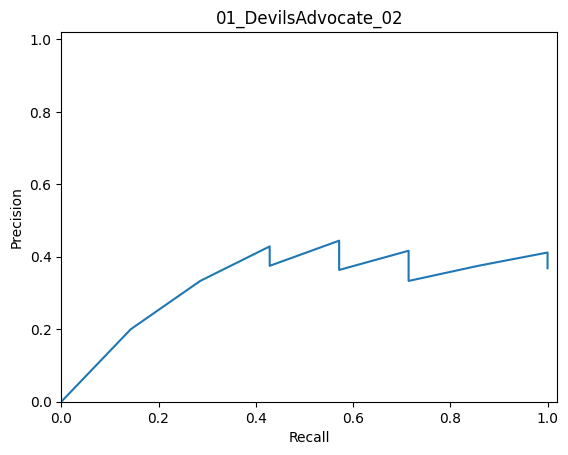

First 5 tracks:
Precision: 0.2
Recall: 0.14285714285714285
F-Measure: 0.1851851851851852

First 10 tracks:
Precision: 0.4
Recall: 0.5714285714285714
F-Measure: 0.425531914893617


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,03_ArcticTale_02,0,0.999999,0.0,0.0,0
1,03_ArcticTale_05,0,0.999998,0.0,0.0,0
2,02_LastDance_04,0,0.999998,0.0,0.0,0
3,03_ArcticTale_04,0,0.999996,0.0,0.0,0
4,01_PulpFiction_02,1,0.999996,0.2,0.142857,0.185185
5,01_DevilsAdvocate_05,1,0.999994,0.333333,0.285714,0.322581
6,01_PulpFiction_05,1,0.999994,0.428571,0.428571,0.428571
7,02_HowSheMove_03,0,0.999993,0.375,0.428571,0.384615
8,01_PulpFiction_03,1,0.999991,0.444444,0.571429,0.465116
9,02_LastDance_05,0,0.999991,0.4,0.571429,0.425532


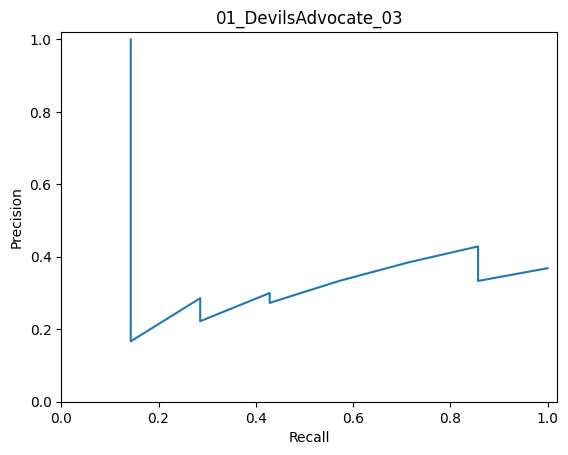

First 5 tracks:
Precision: 0.2
Recall: 0.14285714285714285
F-Measure: 0.1851851851851852

First 10 tracks:
Precision: 0.3
Recall: 0.42857142857142855
F-Measure: 0.3191489361702127


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_DevilsAdvocate_04,1,1.000000,1.0,0.142857,0.454545
1,02_LastDance_02,0,1.000000,0.5,0.142857,0.333333
2,02_LastDance_03,0,1.000000,0.333333,0.142857,0.263158
3,02_HowSheMove_02,0,0.999999,0.25,0.142857,0.217391
4,02_HowSheMove_04,0,0.999999,0.2,0.142857,0.185185
5,02_HowSheMove_05,0,0.999995,0.166667,0.142857,0.16129
6,01_PulpFiction_04,1,0.999993,0.285714,0.285714,0.285714
7,03_ArcticTale_03,0,0.999992,0.25,0.285714,0.25641
8,02_LastDance_05,0,0.999990,0.222222,0.285714,0.232558
9,01_PulpFiction_03,1,0.999989,0.3,0.428571,0.319149


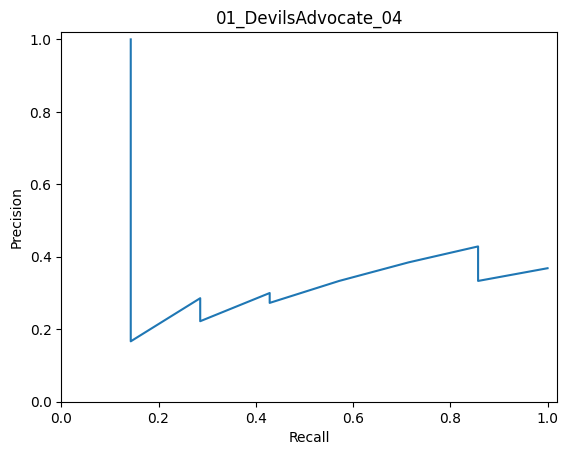

First 5 tracks:
Precision: 0.2
Recall: 0.14285714285714285
F-Measure: 0.1851851851851852

First 10 tracks:
Precision: 0.3
Recall: 0.42857142857142855
F-Measure: 0.3191489361702127


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_DevilsAdvocate_03,1,1.000000,1.0,0.142857,0.454545
1,02_LastDance_02,0,1.000000,0.5,0.142857,0.333333
2,02_LastDance_03,0,1.000000,0.333333,0.142857,0.263158
3,02_HowSheMove_02,0,0.999999,0.25,0.142857,0.217391
4,02_HowSheMove_04,0,0.999999,0.2,0.142857,0.185185
5,02_HowSheMove_05,0,0.999995,0.166667,0.142857,0.16129
6,01_PulpFiction_04,1,0.999993,0.285714,0.285714,0.285714
7,03_ArcticTale_03,0,0.999992,0.25,0.285714,0.25641
8,02_LastDance_05,0,0.999990,0.222222,0.285714,0.232558
9,01_PulpFiction_03,1,0.999989,0.3,0.428571,0.319149


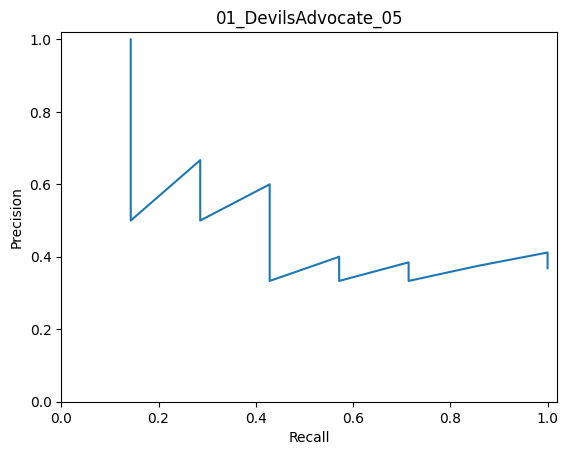

First 5 tracks:
Precision: 0.6
Recall: 0.42857142857142855
F-Measure: 0.5555555555555556

First 10 tracks:
Precision: 0.4
Recall: 0.5714285714285714
F-Measure: 0.425531914893617


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_PulpFiction_05,1,1.000000,1.0,0.142857,0.454545
1,02_HowSheMove_03,0,1.000000,0.5,0.142857,0.333333
2,01_PulpFiction_02,1,1.000000,0.666667,0.285714,0.526316
3,03_ArcticTale_04,0,1.000000,0.5,0.285714,0.434783
4,01_PulpFiction_03,1,1.000000,0.6,0.428571,0.555556
5,02_LastDance_05,0,1.000000,0.5,0.428571,0.483871
6,02_LastDance_04,0,0.999999,0.428571,0.428571,0.428571
7,03_ArcticTale_03,0,0.999999,0.375,0.428571,0.384615
8,03_ArcticTale_05,0,0.999999,0.333333,0.428571,0.348837
9,01_PulpFiction_04,1,0.999999,0.4,0.571429,0.425532


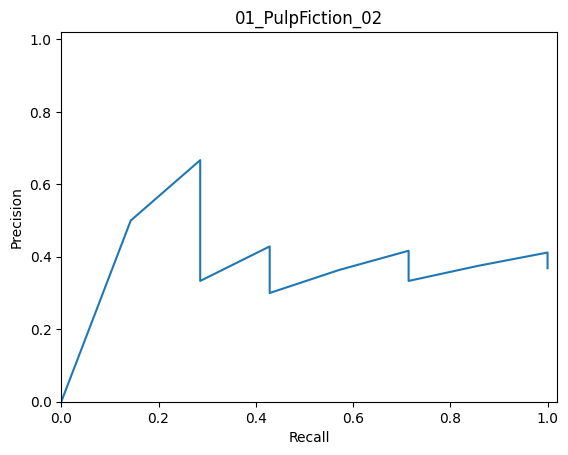

First 5 tracks:
Precision: 0.4
Recall: 0.2857142857142857
F-Measure: 0.3703703703703704

First 10 tracks:
Precision: 0.3
Recall: 0.42857142857142855
F-Measure: 0.3191489361702127


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,03_ArcticTale_04,0,1.000000,0.0,0.0,0
1,01_DevilsAdvocate_05,1,1.000000,0.5,0.142857,0.333333
2,01_PulpFiction_05,1,1.000000,0.666667,0.285714,0.526316
3,02_LastDance_04,0,1.000000,0.5,0.285714,0.434783
4,02_HowSheMove_03,0,1.000000,0.4,0.285714,0.37037
5,03_ArcticTale_05,0,1.000000,0.333333,0.285714,0.322581
6,01_PulpFiction_03,1,0.999999,0.428571,0.428571,0.428571
7,02_LastDance_05,0,0.999999,0.375,0.428571,0.384615
8,03_ArcticTale_02,0,0.999999,0.333333,0.428571,0.348837
9,03_ArcticTale_03,0,0.999998,0.3,0.428571,0.319149


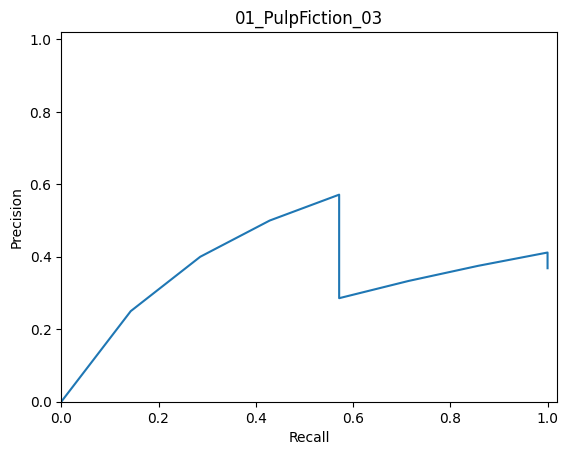

First 5 tracks:
Precision: 0.4
Recall: 0.2857142857142857
F-Measure: 0.3703703703703704

First 10 tracks:
Precision: 0.4
Recall: 0.5714285714285714
F-Measure: 0.425531914893617


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,02_LastDance_05,0,1.000000,0.0,0.0,0
1,02_HowSheMove_03,0,1.000000,0.0,0.0,0
2,03_ArcticTale_03,0,1.000000,0.0,0.0,0
3,01_PulpFiction_05,1,1.000000,0.25,0.142857,0.217391
4,01_DevilsAdvocate_05,1,1.000000,0.4,0.285714,0.37037
5,01_PulpFiction_04,1,1.000000,0.5,0.428571,0.483871
6,01_PulpFiction_02,1,0.999999,0.571429,0.571429,0.571429
7,03_ArcticTale_04,0,0.999999,0.5,0.571429,0.512821
8,02_HowSheMove_05,0,0.999999,0.444444,0.571429,0.465116
9,02_LastDance_04,0,0.999998,0.4,0.571429,0.425532


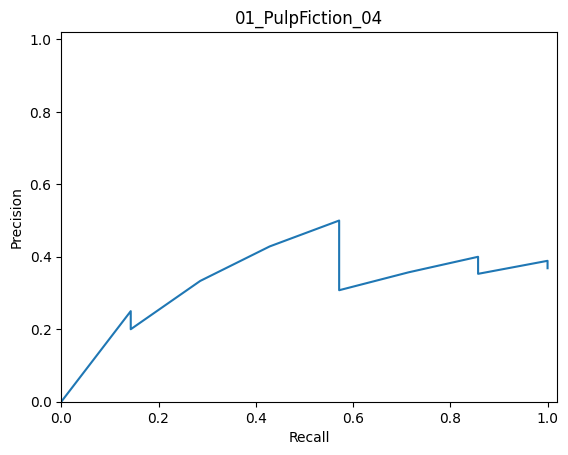

First 5 tracks:
Precision: 0.2
Recall: 0.14285714285714285
F-Measure: 0.1851851851851852

First 10 tracks:
Precision: 0.4
Recall: 0.5714285714285714
F-Measure: 0.425531914893617


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,03_ArcticTale_03,0,1.000000,0.0,0.0,0
1,02_LastDance_05,0,1.000000,0.0,0.0,0
2,02_HowSheMove_05,0,1.000000,0.0,0.0,0
3,01_PulpFiction_03,1,1.000000,0.25,0.142857,0.217391
4,02_HowSheMove_03,0,0.999999,0.2,0.142857,0.185185
5,01_PulpFiction_05,1,0.999999,0.333333,0.285714,0.322581
6,01_DevilsAdvocate_05,1,0.999999,0.428571,0.428571,0.428571
7,01_PulpFiction_02,1,0.999998,0.5,0.571429,0.512821
8,03_ArcticTale_04,0,0.999997,0.444444,0.571429,0.465116
9,02_HowSheMove_02,0,0.999996,0.4,0.571429,0.425532


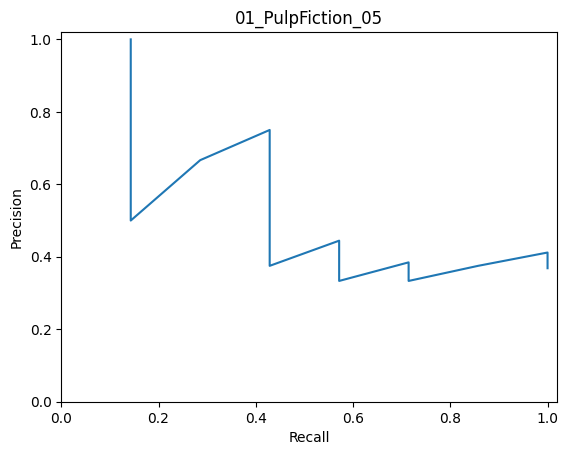

First 5 tracks:
Precision: 0.6
Recall: 0.42857142857142855
F-Measure: 0.5555555555555556

First 10 tracks:
Precision: 0.4
Recall: 0.5714285714285714
F-Measure: 0.425531914893617


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_DevilsAdvocate_05,1,1.000000,1.0,0.142857,0.454545
1,02_HowSheMove_03,0,1.000000,0.5,0.142857,0.333333
2,01_PulpFiction_02,1,1.000000,0.666667,0.285714,0.526316
3,01_PulpFiction_03,1,1.000000,0.75,0.428571,0.652174
4,03_ArcticTale_04,0,1.000000,0.6,0.428571,0.555556
5,02_LastDance_05,0,1.000000,0.5,0.428571,0.483871
6,03_ArcticTale_03,0,0.999999,0.428571,0.428571,0.428571
7,02_LastDance_04,0,0.999999,0.375,0.428571,0.384615
8,01_PulpFiction_04,1,0.999999,0.444444,0.571429,0.465116
9,03_ArcticTale_05,0,0.999999,0.4,0.571429,0.425532


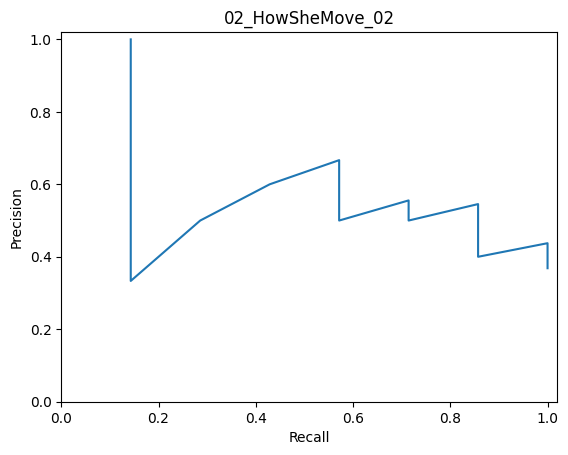

First 5 tracks:
Precision: 0.6
Recall: 0.42857142857142855
F-Measure: 0.5555555555555556

First 10 tracks:
Precision: 0.5
Recall: 0.7142857142857143
F-Measure: 0.5319148936170213


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,02_LastDance_02,1,1.000000,1.0,0.142857,0.454545
1,01_DevilsAdvocate_03,0,0.999999,0.5,0.142857,0.333333
2,01_DevilsAdvocate_04,0,0.999999,0.333333,0.142857,0.263158
3,02_LastDance_03,1,0.999998,0.5,0.285714,0.434783
4,02_HowSheMove_05,1,0.999998,0.6,0.428571,0.555556
5,02_HowSheMove_04,1,0.999996,0.666667,0.571429,0.645161
6,01_PulpFiction_04,0,0.999996,0.571429,0.571429,0.571429
7,03_ArcticTale_03,0,0.999995,0.5,0.571429,0.512821
8,02_LastDance_05,1,0.999994,0.555556,0.714286,0.581395
9,01_PulpFiction_03,0,0.999993,0.5,0.714286,0.531915


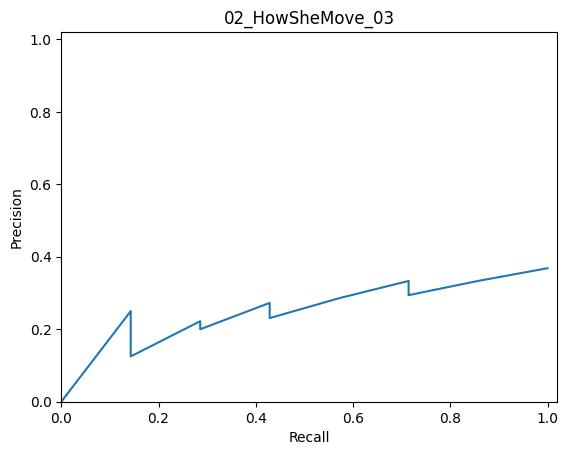

First 5 tracks:
Precision: 0.2
Recall: 0.14285714285714285
F-Measure: 0.1851851851851852

First 10 tracks:
Precision: 0.2
Recall: 0.2857142857142857
F-Measure: 0.2127659574468085


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_PulpFiction_05,0,1.000000,0.0,0.0,0
1,01_DevilsAdvocate_05,0,1.000000,0.0,0.0,0
2,01_PulpFiction_03,0,1.000000,0.0,0.0,0
3,02_LastDance_05,1,1.000000,0.25,0.142857,0.217391
4,01_PulpFiction_02,0,1.000000,0.2,0.142857,0.185185
5,03_ArcticTale_04,0,1.000000,0.166667,0.142857,0.16129
6,03_ArcticTale_03,0,0.999999,0.142857,0.142857,0.142857
7,01_PulpFiction_04,0,0.999999,0.125,0.142857,0.128205
8,02_LastDance_04,1,0.999999,0.222222,0.285714,0.232558
9,03_ArcticTale_05,0,0.999999,0.2,0.285714,0.212766


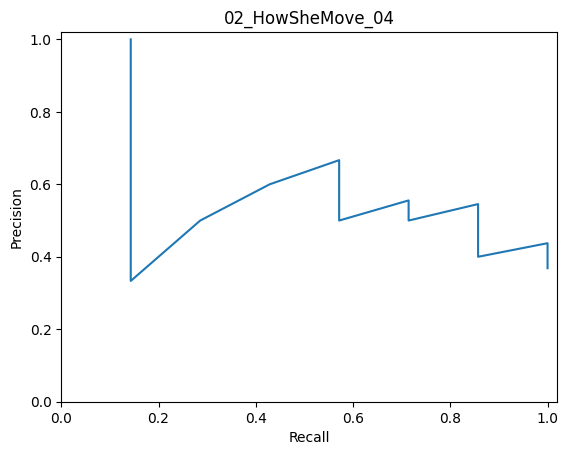

First 5 tracks:
Precision: 0.6
Recall: 0.42857142857142855
F-Measure: 0.5555555555555556

First 10 tracks:
Precision: 0.5
Recall: 0.7142857142857143
F-Measure: 0.5319148936170213


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,02_LastDance_03,1,1.000000,1.0,0.142857,0.454545
1,01_DevilsAdvocate_04,0,0.999999,0.5,0.142857,0.333333
2,01_DevilsAdvocate_03,0,0.999999,0.333333,0.142857,0.263158
3,02_LastDance_02,1,0.999998,0.5,0.285714,0.434783
4,02_HowSheMove_02,1,0.999996,0.6,0.428571,0.555556
5,02_HowSheMove_05,1,0.999989,0.666667,0.571429,0.645161
6,01_PulpFiction_04,0,0.999985,0.571429,0.571429,0.571429
7,03_ArcticTale_03,0,0.999983,0.5,0.571429,0.512821
8,02_LastDance_05,1,0.999981,0.555556,0.714286,0.581395
9,01_PulpFiction_03,0,0.999980,0.5,0.714286,0.531915


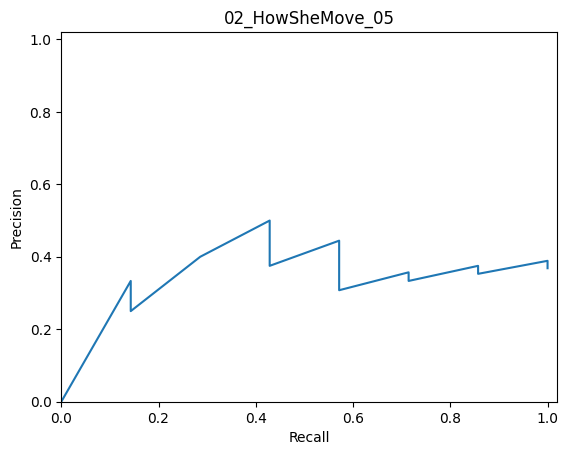

First 5 tracks:
Precision: 0.4
Recall: 0.2857142857142857
F-Measure: 0.3703703703703704

First 10 tracks:
Precision: 0.4
Recall: 0.5714285714285714
F-Measure: 0.425531914893617


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_PulpFiction_04,0,1.000000,0.0,0.0,0
1,03_ArcticTale_03,0,1.000000,0.0,0.0,0
2,02_LastDance_05,1,0.999999,0.333333,0.142857,0.263158
3,01_PulpFiction_03,0,0.999999,0.25,0.142857,0.217391
4,02_HowSheMove_03,1,0.999998,0.4,0.285714,0.37037
5,02_HowSheMove_02,1,0.999998,0.5,0.428571,0.483871
6,01_PulpFiction_05,0,0.999998,0.428571,0.428571,0.428571
7,01_DevilsAdvocate_05,0,0.999997,0.375,0.428571,0.384615
8,02_LastDance_02,1,0.999997,0.444444,0.571429,0.465116
9,01_PulpFiction_02,0,0.999996,0.4,0.571429,0.425532


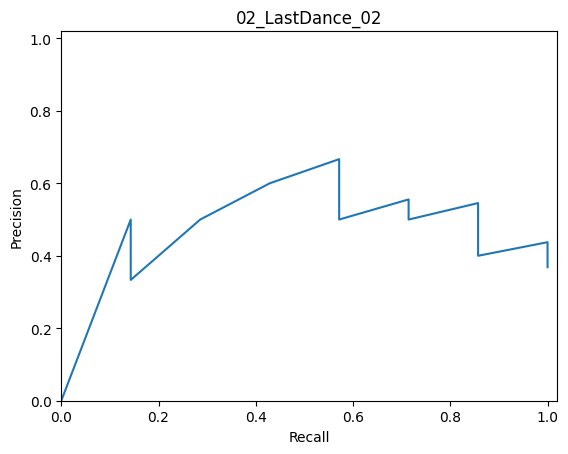

First 5 tracks:
Precision: 0.6
Recall: 0.42857142857142855
F-Measure: 0.5555555555555556

First 10 tracks:
Precision: 0.5
Recall: 0.7142857142857143
F-Measure: 0.5319148936170213


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_DevilsAdvocate_03,0,1.000000,0.0,0.0,0
1,02_HowSheMove_02,1,1.000000,0.5,0.142857,0.333333
2,01_DevilsAdvocate_04,0,1.000000,0.333333,0.142857,0.263158
3,02_LastDance_03,1,0.999999,0.5,0.285714,0.434783
4,02_HowSheMove_04,1,0.999998,0.6,0.428571,0.555556
5,02_HowSheMove_05,1,0.999997,0.666667,0.571429,0.645161
6,01_PulpFiction_04,0,0.999995,0.571429,0.571429,0.571429
7,03_ArcticTale_03,0,0.999994,0.5,0.571429,0.512821
8,02_LastDance_05,1,0.999992,0.555556,0.714286,0.581395
9,01_PulpFiction_03,0,0.999991,0.5,0.714286,0.531915


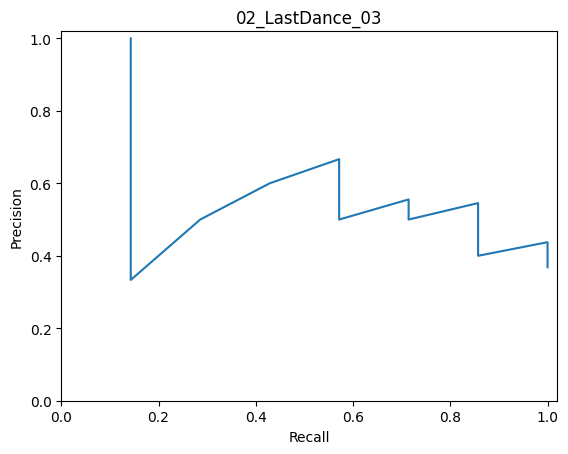

First 5 tracks:
Precision: 0.6
Recall: 0.42857142857142855
F-Measure: 0.5555555555555556

First 10 tracks:
Precision: 0.5
Recall: 0.7142857142857143
F-Measure: 0.5319148936170213


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,02_HowSheMove_04,1,1.000000,1.0,0.142857,0.454545
1,01_DevilsAdvocate_04,0,1.000000,0.5,0.142857,0.333333
2,01_DevilsAdvocate_03,0,1.000000,0.333333,0.142857,0.263158
3,02_LastDance_02,1,0.999999,0.5,0.285714,0.434783
4,02_HowSheMove_02,1,0.999998,0.6,0.428571,0.555556
5,02_HowSheMove_05,1,0.999992,0.666667,0.571429,0.645161
6,01_PulpFiction_04,0,0.999989,0.571429,0.571429,0.571429
7,03_ArcticTale_03,0,0.999987,0.5,0.571429,0.512821
8,02_LastDance_05,1,0.999985,0.555556,0.714286,0.581395
9,01_PulpFiction_03,0,0.999984,0.5,0.714286,0.531915


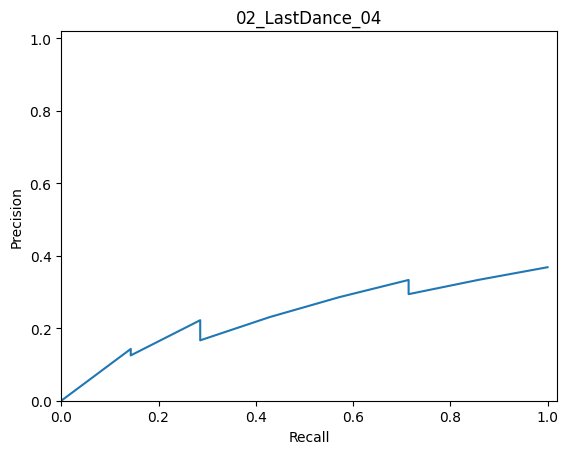

First 5 tracks:
Precision: 0.0
Recall: 0.0
F-Measure: 0

First 10 tracks:
Precision: 0.2
Recall: 0.2857142857142857
F-Measure: 0.2127659574468085


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,03_ArcticTale_05,0,1.000000,0.0,0.0,0
1,03_ArcticTale_04,0,1.000000,0.0,0.0,0
2,01_PulpFiction_02,0,1.000000,0.0,0.0,0
3,03_ArcticTale_02,0,0.999999,0.0,0.0,0
4,01_DevilsAdvocate_05,0,0.999999,0.0,0.0,0
5,01_PulpFiction_05,0,0.999999,0.0,0.0,0
6,02_HowSheMove_03,1,0.999999,0.142857,0.142857,0.142857
7,01_PulpFiction_03,0,0.999998,0.125,0.142857,0.128205
8,02_LastDance_05,1,0.999998,0.222222,0.285714,0.232558
9,01_DevilsAdvocate_02,0,0.999998,0.2,0.285714,0.212766


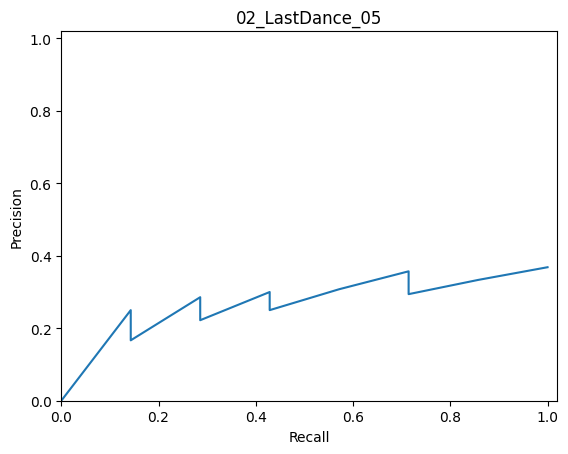

First 5 tracks:
Precision: 0.2
Recall: 0.14285714285714285
F-Measure: 0.1851851851851852

First 10 tracks:
Precision: 0.3
Recall: 0.42857142857142855
F-Measure: 0.3191489361702127


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_PulpFiction_03,0,1.000000,0.0,0.0,0
1,03_ArcticTale_03,0,1.000000,0.0,0.0,0
2,01_PulpFiction_04,0,1.000000,0.0,0.0,0
3,02_HowSheMove_03,1,1.000000,0.25,0.142857,0.217391
4,01_PulpFiction_05,0,1.000000,0.2,0.142857,0.185185
5,01_DevilsAdvocate_05,0,1.000000,0.166667,0.142857,0.16129
6,02_HowSheMove_05,1,0.999999,0.285714,0.285714,0.285714
7,01_PulpFiction_02,0,0.999999,0.25,0.285714,0.25641
8,03_ArcticTale_04,0,0.999999,0.222222,0.285714,0.232558
9,02_LastDance_04,1,0.999998,0.3,0.428571,0.319149


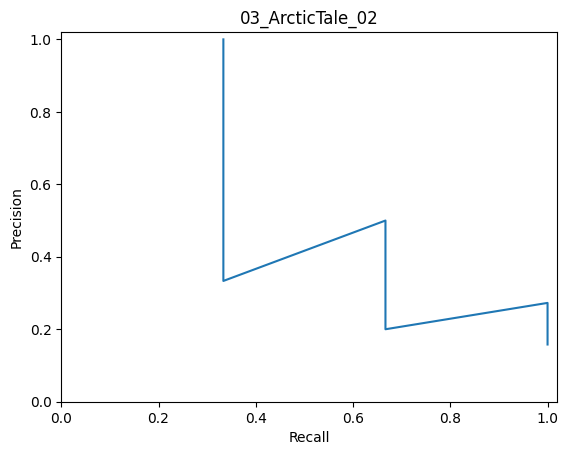

First 5 tracks:
Precision: 0.4
Recall: 0.6666666666666666
F-Measure: 0.43478260869565216

First 10 tracks:
Precision: 0.2
Recall: 0.6666666666666666
F-Measure: 0.23255813953488372


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,03_ArcticTale_05,1,1.000000,1.0,0.333333,0.714286
1,02_LastDance_04,0,0.999999,0.5,0.333333,0.454545
2,01_DevilsAdvocate_02,0,0.999999,0.333333,0.333333,0.333333
3,03_ArcticTale_04,1,0.999999,0.5,0.666667,0.526316
4,01_PulpFiction_02,0,0.999999,0.4,0.666667,0.434783
5,01_DevilsAdvocate_05,0,0.999997,0.333333,0.666667,0.37037
6,01_PulpFiction_05,0,0.999997,0.285714,0.666667,0.322581
7,02_HowSheMove_03,0,0.999997,0.25,0.666667,0.285714
8,01_PulpFiction_03,0,0.999995,0.222222,0.666667,0.25641
9,02_LastDance_05,0,0.999995,0.2,0.666667,0.232558


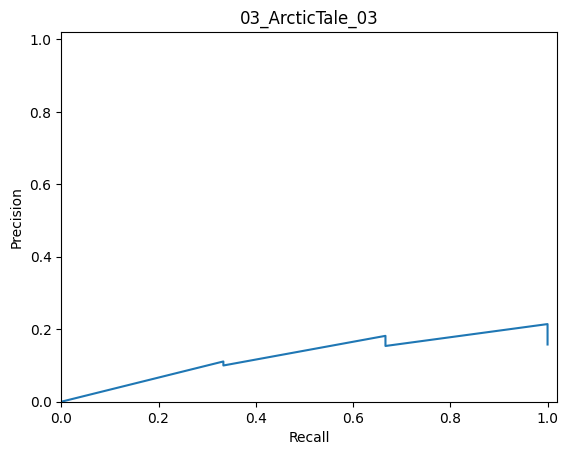

First 5 tracks:
Precision: 0.0
Recall: 0.0
F-Measure: 0

First 10 tracks:
Precision: 0.1
Recall: 0.3333333333333333
F-Measure: 0.11627906976744186


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_PulpFiction_04,0,1.000000,0.0,0.0,0
1,02_LastDance_05,0,1.000000,0.0,0.0,0
2,01_PulpFiction_03,0,1.000000,0.0,0.0,0
3,02_HowSheMove_05,0,1.000000,0.0,0.0,0
4,02_HowSheMove_03,0,0.999999,0.0,0.0,0
5,01_PulpFiction_05,0,0.999999,0.0,0.0,0
6,01_DevilsAdvocate_05,0,0.999999,0.0,0.0,0
7,01_PulpFiction_02,0,0.999998,0.0,0.0,0
8,03_ArcticTale_04,1,0.999998,0.111111,0.333333,0.128205
9,02_LastDance_04,0,0.999997,0.1,0.333333,0.116279


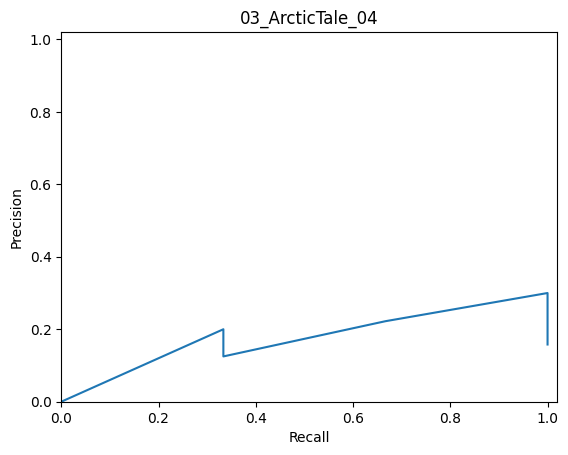

First 5 tracks:
Precision: 0.2
Recall: 0.3333333333333333
F-Measure: 0.21739130434782608

First 10 tracks:
Precision: 0.3
Recall: 1.0
F-Measure: 0.3488372093023256


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,01_PulpFiction_02,0,1.000000,0.0,0.0,0
1,02_LastDance_04,0,1.000000,0.0,0.0,0
2,01_DevilsAdvocate_05,0,1.000000,0.0,0.0,0
3,01_PulpFiction_05,0,1.000000,0.0,0.0,0
4,03_ArcticTale_05,1,1.000000,0.2,0.333333,0.217391
5,02_HowSheMove_03,0,1.000000,0.166667,0.333333,0.185185
6,01_PulpFiction_03,0,0.999999,0.142857,0.333333,0.16129
7,02_LastDance_05,0,0.999999,0.125,0.333333,0.142857
8,03_ArcticTale_02,1,0.999999,0.222222,0.666667,0.25641
9,03_ArcticTale_03,1,0.999998,0.3,1.0,0.348837


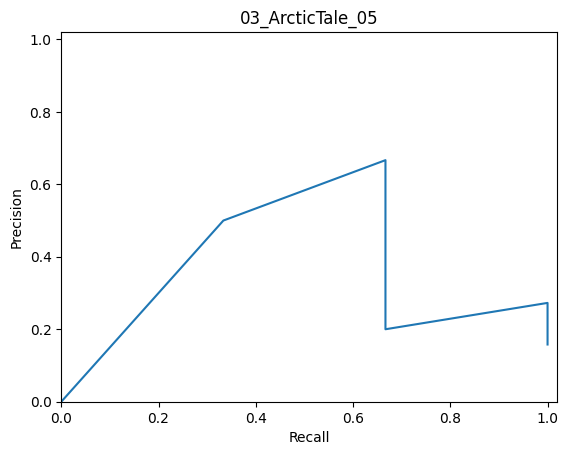

First 5 tracks:
Precision: 0.4
Recall: 0.6666666666666666
F-Measure: 0.43478260869565216

First 10 tracks:
Precision: 0.2
Recall: 0.6666666666666666
F-Measure: 0.23255813953488372


,File,Relevance,Cosine Similarity,Precision,Recall,F
0,02_LastDance_04,0,1.000000,0.0,0.0,0
1,03_ArcticTale_04,1,1.000000,0.5,0.333333,0.454545
2,03_ArcticTale_02,1,1.000000,0.666667,0.666667,0.666667
3,01_PulpFiction_02,0,1.000000,0.5,0.666667,0.526316
4,01_DevilsAdvocate_05,0,0.999999,0.4,0.666667,0.434783
5,01_PulpFiction_05,0,0.999999,0.333333,0.666667,0.37037
6,02_HowSheMove_03,0,0.999999,0.285714,0.666667,0.322581
7,01_DevilsAdvocate_02,0,0.999998,0.25,0.666667,0.285714
8,01_PulpFiction_03,0,0.999998,0.222222,0.666667,0.25641
9,02_LastDance_05,0,0.999997,0.2,0.666667,0.232558


In [180]:
evaluateQueryEngine(dir="../videos/processed")